## Libs



In [1]:
import json
import joblib
# Manipulação e análise de dados
import pandas as pd
import numpy as np
from collections import Counter

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# NLP e pré-processamento
import re
import spacy

# Vetorização de texto
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelagem
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Balanceamento
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline

In [2]:
!python -m spacy download pt_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 81.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
# Função para carregar arquivos JSON
def carregar_json(caminho):
    with open(caminho, 'r', encoding='utf-8') as f:
        return json.load(f)

# Carregar os arquivos
jobs = carregar_json('vagas.json')
prospects = carregar_json('prospects.json')
applicants = carregar_json('applicants.json')

# Converter jobs.json em DataFrame
df_jobs = pd.DataFrame.from_dict(jobs, orient='index').reset_index().rename(columns={'index': 'job_id'})

# Converter applicants.json em DataFrame
df_applicants = pd.DataFrame.from_dict(applicants, orient='index').reset_index().rename(columns={'index': 'applicant_id'})

# Tratar estrutura variada do prospects.json
lista_prospects = []

for job_id, value in prospects.items():
    if isinstance(value, list):
        for candidato in value:
            if isinstance(candidato, dict):
                lista_prospects.append({'job_id': job_id, **candidato})
    elif isinstance(value, dict) and 'prospects' in value:
        for candidato in value['prospects']:
            if isinstance(candidato, dict):
                lista_prospects.append({'job_id': job_id, **candidato})
    else:
        print(f"[AVISO] Estrutura inesperada na vaga {job_id}: {type(value)}")

df_prospects = pd.DataFrame(lista_prospects)

In [4]:
# Unir os dados: prospects + applicants + jobs
df_merge = df_prospects.merge(df_applicants, left_on='codigo', right_on='applicant_id', how='left')
df_merge = df_merge.merge(df_jobs, on='job_id', how='left')
print("Formato final da base:", df_merge.shape)
display(df_merge.head())


Formato final da base: (53759, 19)


,job_id,nome,codigo,situacao_candidado,data_candidatura,ultima_atualizacao,comentario,recrutador,applicant_id,infos_basicas,informacoes_pessoais,informacoes_profissionais,formacao_e_idiomas,cargo_atual,cv_pt,cv_en,informacoes_basicas,perfil_vaga,beneficios
0,4530,José Vieira,25632,Encaminhado ao Requisitante,25-03-2021,25-03-2021,"Encaminhado para - PJ R$ 72,00/hora",Ana Lívia Moreira,25632,"{'telefone_recado': '', 'telefone': '(21) 9348...",{'data_aceite': 'Cadastro anterior ao registro...,"{'titulo_profissional': '', 'area_atuacao': ''...","{'nivel_academico': '', 'nivel_ingles': '', 'n...",{},\ndados pessoais\nestado civil: casado\nidade:...,,"{'data_requicisao': '10-03-2021', 'limite_espe...","{'pais': 'Brasil', 'estado': 'Rio de Janeiro',...","{'valor_venda': '-', 'valor_compra_1': 'R$', '..."
1,4530,Srta. Isabela Cavalcante,25529,Encaminhado ao Requisitante,22-03-2021,23-03-2021,"encaminhado para - R$ 6.000,00 – CLT Full , n...",Ana Lívia Moreira,25529,"{'telefone_recado': '', 'telefone': '(21) 9426...",{'data_aceite': 'Cadastro anterior ao registro...,{'titulo_profissional': 'ANALISTA DE REDES E T...,{'nivel_academico': 'Ensino Superior Completo'...,{},"solteiro, 47 anos\n\nestrada meringuava, nº 17...",,"{'data_requicisao': '10-03-2021', 'limite_espe...","{'pais': 'Brasil', 'estado': 'Rio de Janeiro',...","{'valor_venda': '-', 'valor_compra_1': 'R$', '..."
2,4531,Sra. Yasmin Fernandes,25364,Contratado pela Decision,17-03-2021,12-04-2021,Data de Inicio: 12/04/2021,Juliana Cassiano,25364,"{'telefone_recado': '', 'telefone': '(21) 9633...",{'data_aceite': 'Cadastro anterior ao registro...,{'titulo_profissional': 'Liderança / Desenvolv...,{'nivel_academico': 'Ensino Superior Completo'...,{},\n\nárea de atuação: lider de consultoria / ge...,,"{'data_requicisao': '10-03-2021', 'limite_espe...","{'pais': 'Brasil', 'estado': 'São Paulo', 'cid...","{'valor_venda': '-', 'valor_compra_1': 'hora',..."
3,4531,Alexia Barbosa,25360,Encaminhado ao Requisitante,17-03-2021,17-03-2021,,Juliana Cassiano,25360,"{'telefone_recado': '', 'telefone': '(11) 9774...",{'data_aceite': 'Cadastro anterior ao registro...,"{'titulo_profissional': '', 'area_atuacao': ''...","{'nivel_academico': '', 'nivel_ingles': '', 'n...",{},informações pessoais\n estado civil: casado\n...,,"{'data_requicisao': '10-03-2021', 'limite_espe...","{'pais': 'Brasil', 'estado': 'São Paulo', 'cid...","{'valor_venda': '-', 'valor_compra_1': 'hora',..."
4,4533,Arthur Almeida,26338,Contratado pela Decision,29-04-2021,18-05-2021,,Stella Vieira,26338,"{'telefone_recado': '', 'telefone': '(31) 9270...","{'data_aceite': '25/11/2022 11:04', 'nome': 'A...","{'titulo_profissional': '', 'area_atuacao': ''...","{'nivel_academico': '', 'nivel_ingles': '', 'n...",{},"solteiro, brasileiro, 21/06/1987\nhabilitação ...",,"{'data_requicisao': '11-03-2021', 'limite_espe...","{'pais': 'Brasil', 'estado': 'São Paulo', 'cid...","{'valor_venda': '207,00 -', 'valor_compra_1': ..."


In [5]:
df_merge['situacao_candidado'].unique()

array(['Encaminhado ao Requisitante', 'Contratado pela Decision',
       'Desistiu', 'Documentação PJ', 'Não Aprovado pelo Cliente',
       'Prospect', 'Não Aprovado pelo RH', 'Aprovado',
       'Não Aprovado pelo Requisitante', 'Inscrito', 'Entrevista Técnica',
       'Em avaliação pelo RH', 'Contratado como Hunting',
       'Desistiu da Contratação', 'Entrevista com Cliente',
       'Documentação CLT', 'Recusado', 'Documentação Cooperado',
       'Sem interesse nesta vaga', 'Encaminhar Proposta',
       'Proposta Aceita'], dtype=object)

In [6]:
df_merge['situacao_candidado'].value_counts()

,count
situacao_candidado,
Prospect,20021
Encaminhado ao Requisitante,16122
Inscrito,3980
Não Aprovado pelo Cliente,3492
Contratado pela Decision,2758
Desistiu,2349
Não Aprovado pelo RH,1765
Não Aprovado pelo Requisitante,765
Entrevista Técnica,579


In [7]:
# Categorias que podem indicar sucesso na contratação, mas aí tem que ver
categorias_contratado = [
    'Contratado pela Decision',
    'Contratado como Hunting',
    'Proposta Aceita'
]

# Criando a variável alvo
df_merge['target_contratado'] = df_merge['situacao_candidado'].apply(lambda x: 1 if x in categorias_contratado else 0)

#distribuição
df_merge['target_contratado'].value_counts(normalize=True).rename(index={1: 'Contratado', 0: 'Não contratado'})

,proportion
target_contratado,
Não contratado,0.944474
Contratado,0.055526


In [8]:
# Verificar colunas com mais de 50% de valores nulos
df_merge.isnull().mean().sort_values(ascending=False).head(20)

,0
applicant_id,0.161164
infos_basicas,0.161164
informacoes_pessoais,0.161164
informacoes_profissionais,0.161164
cv_en,0.161164
cv_pt,0.161164
cargo_atual,0.161164
formacao_e_idiomas,0.161164
informacoes_basicas,0.000446
perfil_vaga,0.000446


In [9]:
# Preencher nulos com string vazia
df_modelo = df_merge.copy()
colunas_texto = ['formacao_e_idiomas', 'cargo_atual', 'perfil_vaga', 'beneficios','informacoes_profissionais', 'infos_basicas']
df_modelo[colunas_texto] = df_modelo[colunas_texto].fillna('')

# Criar coluna de texto consolidado
df_modelo['texto_geral'] = df_modelo[colunas_texto].astype(str).agg(' '.join, axis=1)

In [10]:
# Carregar modelo pré-treinado em português
nlp = spacy.load('pt_core_news_sm')

# Função para extrair entidades
def extrair_entidades(texto):
    doc = nlp(texto)
    return [(ent.text, ent.label_) for ent in doc.ents]

# Aplicar no df
df_modelo['entidades'] = df_modelo['texto_geral'].apply(extrair_entidades)

df_modelo[['texto_geral', 'entidades']].head(3)

,texto_geral,entidades
0,"{'nivel_academico': '', 'nivel_ingles': '', 'n...","[(Brasil, LOC), (Rio de Janeiro, LOC), (Rio de..."
1,{'nivel_academico': 'Ensino Superior Completo'...,"[(Ensino Superior Completo, PER), (Intermediár..."
2,{'nivel_academico': 'Ensino Superior Completo'...,"[(Ensino Superior Completo, PER), (Avançado, L..."


In [ ]:
# Explodir entidades em várias linhas
df_ents = df_modelo[['entidades']].explode('entidades')
df_ents[['texto', 'entidade']] = pd.DataFrame(df_ents['entidades'].tolist(), index=df_ents.index)
df_ents

###  Top 10 entidades mais frequentes por tipo

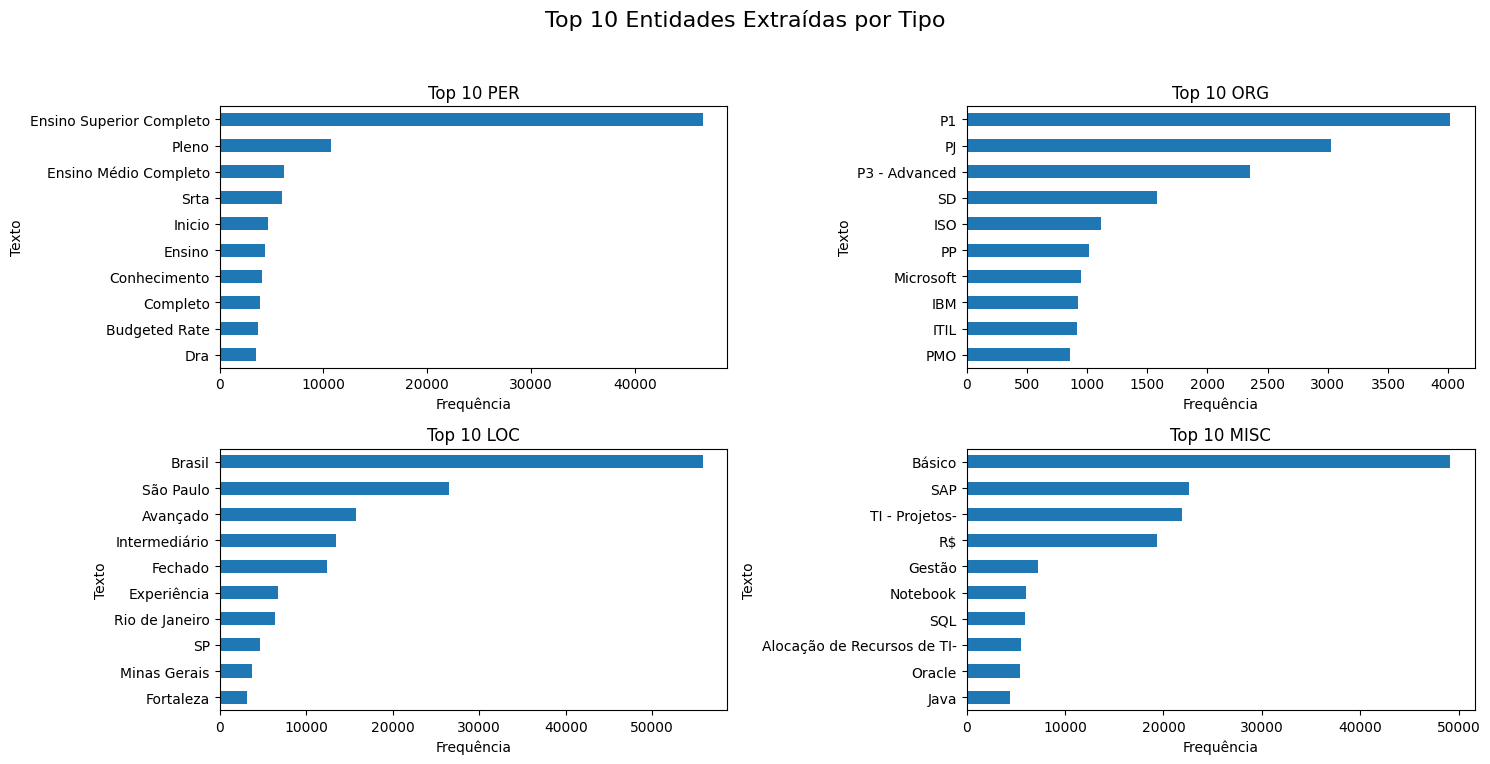

In [11]:
# Função para plotar gráfico horizontal para entidade
def plot_top_entidades(df_ents, entidade, ax):
    top = df_ents[df_ents['entidade'] == entidade]['texto'].value_counts().head(10)
    top.sort_values().plot(kind='barh', ax=ax)
    ax.set_title(f'Top 10 {entidade}')
    ax.set_xlabel('Frequência')
    ax.set_ylabel('Texto')

# Criar figura com 2 linhas e 2 colunas de gráficos
fig, axs = plt.subplots(2, 2, figsize=(15, 8))
fig.suptitle('Top 10 Entidades Extraídas por Tipo', fontsize=16)

# Plotar cada gráfico
plot_top_entidades(df_ents, 'PER', axs[0, 0])
plot_top_entidades(df_ents, 'ORG', axs[0, 1])
plot_top_entidades(df_ents, 'LOC', axs[1, 0])
plot_top_entidades(df_ents, 'MISC', axs[1, 1])

# Ajustar layout para que os títulos não sobreponham
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [12]:
# Função para criar colunas binárias apenas com os top termos de cada tipo
df_modelo_enriquecido = df_modelo.copy()

for tipo in ['PER', 'ORG', 'LOC', 'MISC']:
    top_termos = df_ents[df_ents['entidade'] == tipo]['texto'].value_counts().head(20).index
    for termo in top_termos:
        coluna = f'{tipo}_{termo}'.replace(" ", "_").lower()
        df_modelo_enriquecido[coluna] = df_modelo['entidades'].apply(lambda lista: int((termo, tipo) in lista))



df_modelo_enriquecido.filter(regex='^(per|org|loc|misc)_').head()

,per_ensino_superior_completo,per_pleno,per_ensino_médio_completo,per_srta,per_inicio,per_ensino,per_conhecimento,per_completo,per_budgeted_rate,per_dra,...,misc_ti_-_desenvolvimento/programação-,misc_hourly/daily,misc_clt,misc_pós_graduação_completo,misc_aws,misc_javascript,misc_ti_-_desenvolvimento/programação,misc_python,misc_html,misc_ti
0,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,1,0,1,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Dividindo em treino e teste

In [13]:
# Selecionar colunas com prefixos de entidades
colunas_entidades = df_modelo_enriquecido.filter(regex='^(per|org|loc|misc)_').columns.tolist()

# Definir X e y
X = df_modelo_enriquecido[colunas_entidades]
y = df_modelo_enriquecido['target_contratado']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=1995)

### Teste de Baseline com RL e RF

In [14]:
## Treinar Random Forest
#rf = RandomForestClassifier(random_state=1995)
#rf.fit(X_train, y_train)
#y_pred_rf = rf.predict(X_test)
#
## Treinar Regressão Logística
#lr = LogisticRegression(max_iter=1000, random_state=1995)
#lr.fit(X_train, y_train)
#y_pred_lr = lr.predict(X_test)
#
## Avaliação
#print("=== Random Forest ===")
#print(classification_report(y_test, y_pred_rf))
#
#print("=== Regressão Logística ===")
#print(classification_report(y_test, y_pred_lr))


##  Salvar X_train, X_test, y_train, y_test

In [15]:
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)